In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline


import csv
import matplotlib.mlab as mlab
import os
import glob
%matplotlib inline
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy import optimize
from scipy.signal import savgol_filter
from readTRC import readTrc
from scipy.fftpack import rfft, irfft, fftfreq

In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def find_vals(X,Y,cut):
    dataX = X[cut:]
    dataY = Y[cut:]
    minn = min(dataY)
    sig_val = minn*0.5
    MeanLoc = np.where(dataY==minn)[0][0]
    Mean = dataX[MeanLoc]
    L = dataY[0:MeanLoc]
    R = dataY[MeanLoc:len(dataY)]
    LP =find_nearest(L,sig_val)
    RP =find_nearest(R,sig_val)
    whereL = np.where(L==LP)[0][0]
    whereR = np.where(R==RP)[0][0]
    Lpoint = dataX[whereL]
    Rpoint = dataX[MeanLoc+whereR]
    FWHM = (Rpoint-Lpoint)   
    return (Mean,FWHM)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
cd /Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/090718-bottel-2bar-FG

/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/090718-bottel-2bar-FG


In [22]:
#PATH = '/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/090418-cleaned-2bar/'
files = glob.glob('*.txt')
#files.remove('.DS_Store')
files.sort()
#files.remove('200-dirty.txt')
files

['125.txt', '150.txt', '175.txt', '200-dirty.txt', '200.txt']

In [23]:
names = []
for q in range(0,len(files)):
    na = files[q].split('.')[0]
    names.append(na)
names

['125', '150', '175', '200-dirty', '200']

In [24]:
ml = 1e3
Xvals=dict()
Yvals=dict()
for q in range(0,len(files)):
    Hold = np.loadtxt(files[q])
    Xvals[q] = Hold[0]*ml
    Yvals[q] = Hold[1]*ml

In [25]:
col = ['b','g','r','y','m','gray','salmon']

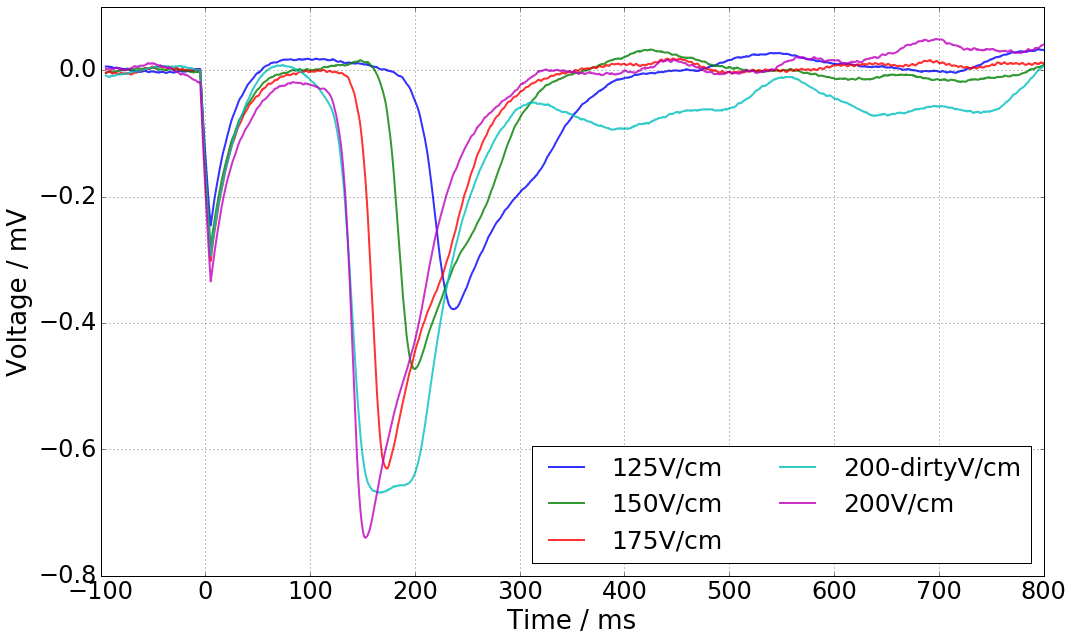

In [26]:
plt.figure(figsize=(15,9))

for q in range(0,len(files)):
    PP=100
    eh = 80
    XX = moving_average(Xvals[q],PP)
    YY = moving_average(Yvals[q],PP)
    plt.plot(XX,YY,label=(names[q]+''+'V/cm'),alpha=0.8,linewidth=2)
    #XX = savgol_filter(XvalsB[q],P,PP)
    #YY = savgol_filter(YvalsB[q],P,PP)
    #plt.plot(XX[0::eh],YY[0::eh],label=(names[q]+''+'V/cm'),alpha=0.8,color=col[q],linestyle='--',linewidth=2)
    
#plt.plot(Xvals[0]*ml,Yvals[0]*ml,color='m')  
plt.xlim(-100,800)
plt.ylim(-0.8,.1)
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='lower right',fontsize=25,ncol=2)
plt.tight_layout()
#plt.savefig('ions-comp-shape-FGG.tif')
plt.show()

In [27]:
def gaussian(x, height, center, width):
    return height*np.exp(-(x - center)**2/(2*width**2))

def two_gaussians(x, h1, c1, w1,
                  h2, c2, w2):
    return (gaussian(x, h1, c1, w1) +
            gaussian(x, h2, c2, w2) )

def gauss_fit_vals(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    vals = [minn,Mean,20,minn*.6,Mean+100,20]
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Y,min(Y[2*Cut:]))
    minPulse     = np.where(Y==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return int(SignalCut)

In [28]:
CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals(Xhot[CUT:],Yhot[CUT:])

errfunc = lambda p, x, y: (two_gaussians(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[CUT:],Yhot[CUT:]))
optim

NameError: name 'Xhot' is not defined

In [11]:
col = ['b','g','r','m','gray','salmon']

In [30]:
len(files)

5

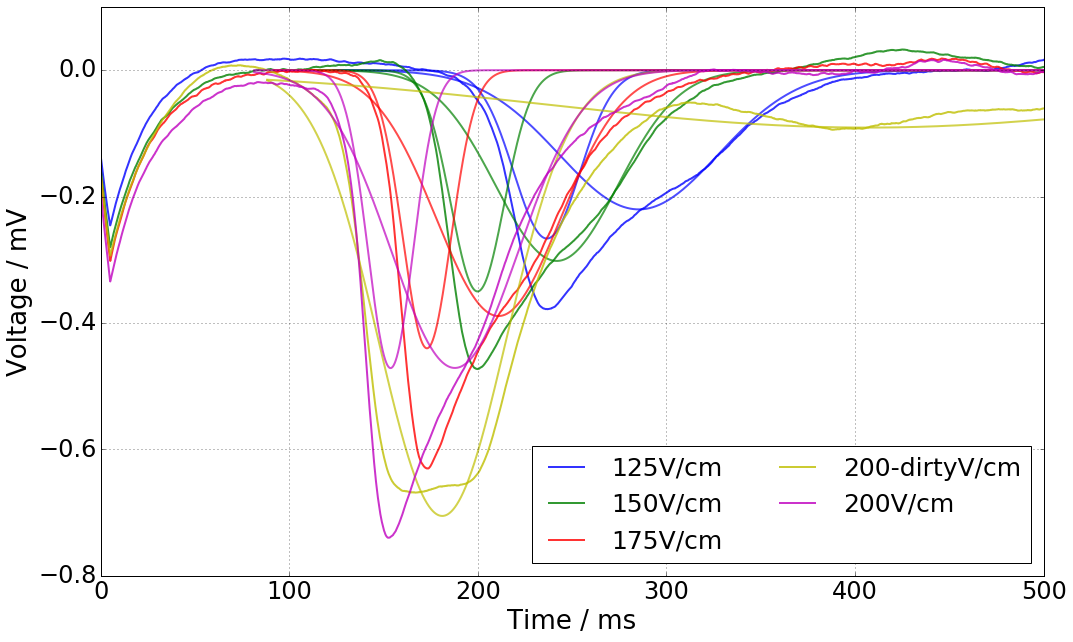

In [32]:
plt.figure(figsize=(15,9))

for q in range(0,len(files)):
    PP=100
    eh = 80
    XX = moving_average(Xvals[q],PP)
    YY = moving_average(Yvals[q],PP)
    plt.plot(XX,YY,label=(names[q]+''+'V/cm'),color=col[q],alpha=0.8,linewidth=2)
    
    CUT = SignalCut(XX,YY)
    fitval = gauss_fit_vals(XX[CUT:],YY[CUT:])
    errfunc = lambda p, x, y: (two_gaussians(x, *p) - y)**2
    optim, success = optimize.leastsq(errfunc, fitval, args=(XX[CUT:],YY[CUT:]))
    
    y1 = gaussian(XX[CUT:],*optim[0:3])
    y2 = gaussian(XX[CUT:],*optim[3:6])
    plt.plot(XX[CUT:],y1,color=col[q],lw=2,alpha=0.7)
    plt.plot(XX[CUT:],y2,color=col[q],lw=2,alpha=0.7)
    
 
plt.xlim(0,500)
plt.ylim(-0.8,.1)
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='lower right',fontsize=25,ncol=2)
plt.tight_layout()
#plt.savefig('ions-comp-shape-FGG.tif')
plt.show()

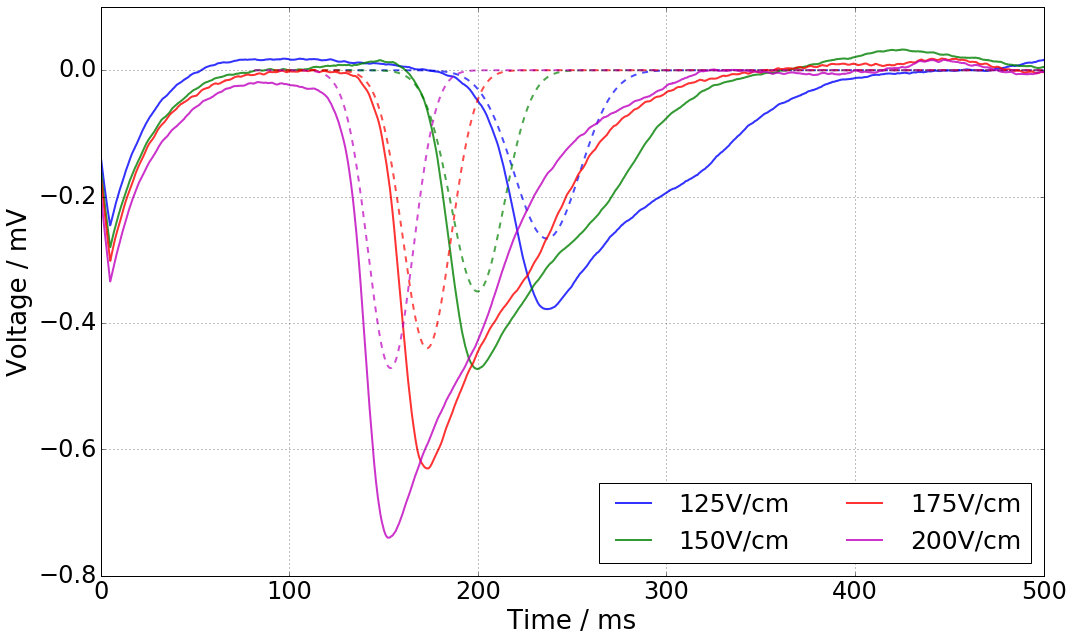

In [13]:
plt.figure(figsize=(15,9))

for q in range(0,len(files)):
    PP=100
    eh = 80
    XX = moving_average(Xvals[q],PP)
    YY = moving_average(Yvals[q],PP)
    plt.plot(XX,YY,label=(names[q]+''+'V/cm'),color=col[q],alpha=0.8,linewidth=2)
    
    CUT = SignalCut(XX,YY)
    fitval = gauss_fit_vals(XX[CUT:],YY[CUT:])
    errfunc = lambda p, x, y: (two_gaussians(x, *p) - y)**2
    optim, success = optimize.leastsq(errfunc, fitval, args=(XX[CUT:],YY[CUT:]))
    
    y1 = gaussian(XX[CUT:],*optim[0:3])
    #y2 = gaussian(XX[CUT:],*optim[3:6])
    plt.plot(XX[CUT:],y1,color=col[q],linestyle='--',lw=2,alpha=0.7)
    #plt.plot(XX[CUT:],y2,color=col[q],lw=2,alpha=0.7)
    
 
plt.xlim(0,500)
plt.ylim(-0.8,.1)
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='lower right',fontsize=25,ncol=2)
plt.tight_layout()
#plt.savefig('ions-comp-shape-FGG.tif')
plt.show()

In [17]:
Efield=[]
FWHM = []
DT = []
T = []
Velocity1 = []
Velocity2 = []
for q in range(0,len(files)):
    PP=100
    eh = 80
    XX = moving_average(Xvals[q],PP)
    YY = moving_average(Yvals[q],PP)
    
    CUT = SignalCut(XX,YY)
    fitval = gauss_fit_vals(XX[CUT:],YY[CUT:])
    errfunc = lambda p, x, y: (two_gaussians(x, *p) - y)**2
    optim, success = optimize.leastsq(errfunc, fitval, args=(XX[CUT:],YY[CUT:]))
    
    V      = 20/(optim[1]*1e-3)
    Velocity1.append(V)
    V      = 20/(optim[4]*1e-3)
    Velocity2.append(V)
    DT.append(optim[4]-optim[1])
    T.append(optim[1])
    Efield.append(float(names[q]))
    
    FWHM.append(optim[2]*2.355)
    #y1 = gaussian(XX[CUT:],*optim[0:3])
    #y2 = gaussian(XX[CUT:],*optim[3:6])
Velocity1 = np.array(Velocity1)
Velocity2 = np.array(Velocity2)
FWHM = np.array(FWHM)
Efield = np.array(Efield)

array([ 0.17391424,  7.4979328 ])

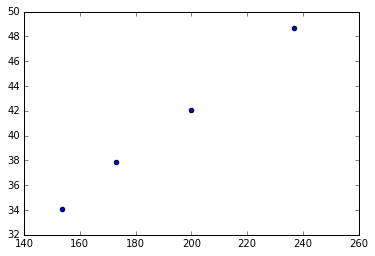

In [19]:
plt.scatter(T,DT)
vals = np.polyfit(T,DT,1)

vals

V1 slope = 1.21732172857
V2 slope = 0.96984150881


//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


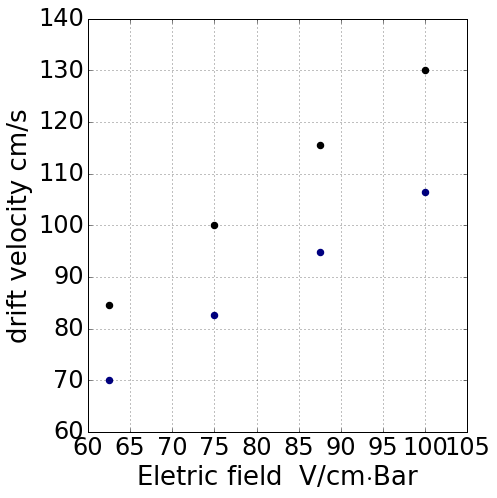

In [16]:
plt.figure(figsize=(7,7))
plt.scatter(Efield/2,Velocity1,color='k',linewidth=3)
plt.scatter(Efield/2,Velocity2,color='navy',linewidth=3)

vals = np.polyfit(Efield/2,Velocity1,1)
print('V1 slope =',vals[0])

vals = np.polyfit(Efield/2,Velocity2,1)
print('V2 slope =',vals[0])

#plt.xlim(0,105)
#plt.ylim(20,155)
plt.xlabel(r'Eletric field  V/cm$\cdot$Bar',fontsize=26)
plt.ylabel(r'drift velocity cm/s',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=25)
plt.tight_layout()
#plt.savefig('drift-both.tif')
plt.show()

In [51]:
TriggerTime = find_nearest(Xvals[0],0)
Trigger     = np.where(Xvals[0]==TriggerTime)[0][0]
Cut = 2*Trigger


In [10]:
time,width = find_vals(Xvals[0],Yvals[0],Cut)
time

176.76984088402659

In [61]:
Velocity=[]
Efield =[]
FWHM  =[]
for q in range(0,len(files)):
    time,width = find_vals(XvalsC[q],YvalsC[q],Cut)
    V      = 20/(time*1e-3)
    Velocity.append(V)
    Efield.append(float(names[q]))
    FWHM.append(width)

In [62]:
for q in range(0,len(files)):
    time,width = find_vals(XvalsB[q],YvalsB[q],Cut)
    V      = 20/(time*1e-3)
    Velocity.append(V)
    Efield.append(float(names[q]))
    FWHM.append(width)
Velocity = np.array(Velocity)
Efield = np.array(Efield)
FWHM = np.array(FWHM)

In [56]:
Velocity

array([  35.37255691,   60.45032492,   75.95617018,   95.4971666 ,
        113.14147198,  127.41365073,  150.72845827,   29.44425133,
         44.54241724,   57.59550985,   72.09034967,   85.11729887,
         97.3943506 ,  110.9202373 ])

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


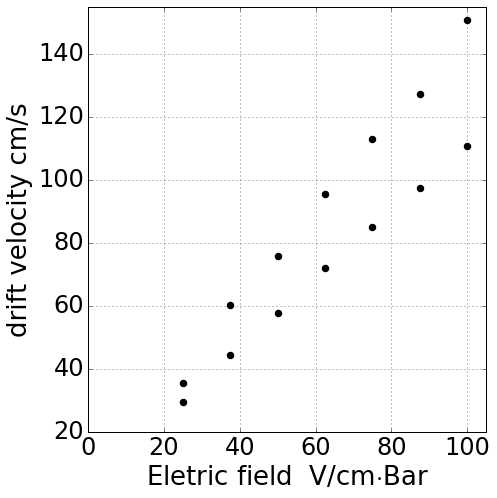

In [58]:
plt.figure(figsize=(7,7))
plt.scatter(Efield/2,Velocity,color='k',linewidth=3)

plt.xlim(0,105)
plt.ylim(20,155)
plt.xlabel(r'Eletric field  V/cm$\cdot$Bar',fontsize=26)
plt.ylabel(r'drift velocity cm/s',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=25)
plt.tight_layout()
#plt.savefig('drift-both.tif')
plt.show()

In [36]:
Efield, FWHM = zip(*sorted(zip(Efield, FWHM)))
Efield = np.array(Efield)
FWHM = np.array(FWHM)

In [37]:
def ef(E,a):
    return a/(E)**(4/3)

popt,pcov = curve_fit(ef,Efield,FWHM)
popt
pcov

array([[ 1956730.77117964]])

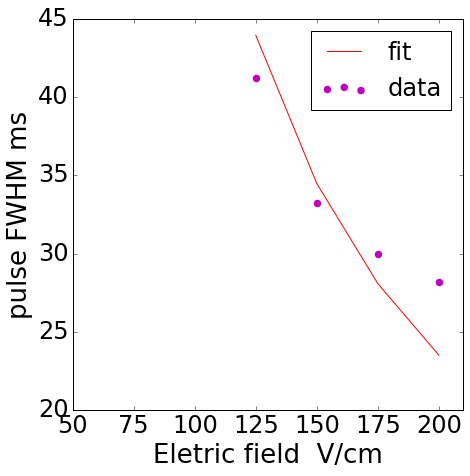

In [38]:
def ef(E,a):
    return a/(E)**(4/3)

popt,pcov = curve_fit(ef,Efield,FWHM)

'''dof = len(y)-len(popt)

plt.plot(x,y,'k+:',label='data')
plt.plot(x,exp_gaus(x,*popt),'r',label='fit')
plt.legend()
plt.axvline(x[(np.where(exp_gaus(x,*popt) == max(exp_gaus(x,*popt))))[0][0]], color='k', linestyle=':')
plt.xlabel('Bins')
plt.ylabel('Counts')
chi = chisquare(y,exp_gaus(x,*popt))
print("Chi-Squared/ndf =", chi[0]/dof)'''




plt.figure(figsize=(7,7))
plt.scatter(Efield,FWHM,color='m',linewidth=3,label='data')
plt.plot(Efield,ef(Efield,*popt),'r',label='fit')

plt.xlabel(r'Eletric field  V/cm',fontsize=26)
plt.ylabel(r'pulse FWHM ms',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xticks(np.arange(50, 210, 25))

plt.legend(loc="upper right",fontsize=24)
plt.show()

In [41]:
x = np.log(Efield)
y = np.log(FWHM)
poly=np.polyfit(x,y,1)

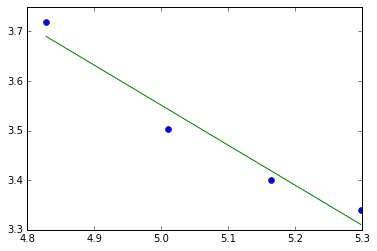

In [42]:
plt.plot(x,y,'o')
plt.plot(x,np.poly1d(poly)(x))

In [43]:
poly

array([-0.80688281,  7.58582381])